In [42]:
from grand_scripts import load_sequences
from sequence_pairs import make_cgr
from cgr_model import SingleModel, POSSIBLE_PARAMS_SOLO
import cgr_model
from os.path import join, exists
from os import mkdir
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import random
import pandas as pd
import csv

# Host-Pathogen read prediction

## Data preparation

Read in known CDS sequences for each of the two genomes

In [26]:
directory = 'data/0010_host_pathogen_read_classification'
mo_seq_dict = load_sequences(join(directory, 'Magnaporthe_oryzae.MG8.cds.all.fa'))
os_seq_dict = load_sequences(join(directory, 'Oryza_sativa.IRGSP-1.0.cds.all.fa'))

In [27]:
host_label = 0
pathogen_label = 1

In [28]:
# Take in a dictionary of CDSs and create a CGR for each sequence.
# Make a list of the same length (y) containing a label for classification
# Also, add all CGRs to a single image to get a visual representation of the whole genome
def build_genome_cgrs(sequence_dict, k, label):
    side_len=2**k
    genome_cgr = np.zeros((side_len,side_len))
    x = []
    y = [label]*len(sequence_dict)
    for key in sequence_dict:
        new_cgr = make_cgr(str(sequence_dict[key].seq), k, False)
        x.append(new_cgr)
        genome_cgr += new_cgr / np.amax(new_cgr)
    return x, y, genome_cgr/np.max(genome_cgr)

In [29]:
# Create CGRs for Magnaporthe oryzae
training_x_mo, training_y_mo, genome_cgr_mo = build_genome_cgrs(mo_seq_dict, 4, pathogen_label)

In [30]:
# Create CGRs for Oryza Sativa
training_x_os, training_y_os, genome_cgr_os = build_genome_cgrs(os_seq_dict, 4, host_label)

Save the created data and labels to use as training data

In [31]:
train_x = np.concatenate((training_x_mo, training_x_os), axis=0)
train_y = np.concatenate((training_y_mo, training_y_os), axis=0)
np.random.seed(1)
inds = np.random.permutation(range(len(train_y)))
train_y = train_y[inds]
train_x = train_x[inds,:,:]
np.savez('data/0010_host_pathogen_read_classification/0010_training_data.npz',train_x=train_x, train_y=train_y)

PATHOGEN


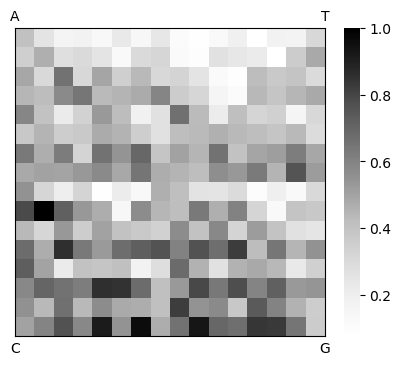

HOST


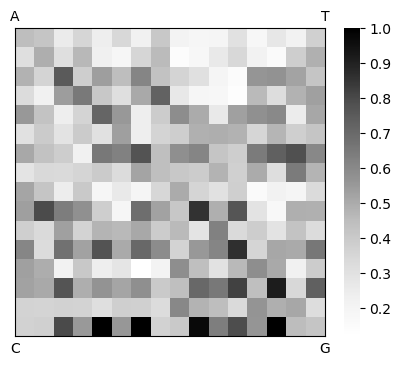

In [32]:
def plot_heatmap(hm):
    plt.figure(figsize=(5,4))
    ax=sb.heatmap(hm,cmap='Greys')
    plt.xticks([0,16],['C','G'])
    plt.yticks([])
    plt.tick_params(length=0)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks([0,16])
    ax2.set_xticklabels(['A','T'])
    plt.tick_params(length=0)
    plt.show()
    

print('PATHOGEN')
plot_heatmap(genome_cgr_mo)

print('HOST')
plot_heatmap(genome_cgr_os)

Plot difference between two genomes

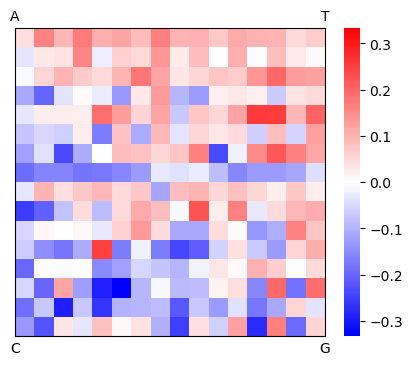

In [33]:
diffs = genome_cgr_os-genome_cgr_mo
diffrange = np.max((np.max(diffs), abs(np.min(diffs))))
plt.figure(figsize=(5,4))
ax=sb.heatmap(diffs,cmap='bwr', vmin=-diffrange, vmax=diffrange)
plt.xticks([0,16],['C','G'])
plt.yticks([])
plt.tick_params(length=0)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([0,16])
ax2.set_xticklabels(['A','T'])
plt.tick_params(length=0)
plt.show()

### Generate simulated reads

We used ART to simulate Illumina reads using the following script:


    #!/bin/sh

    LEN=150
    COV=1
    art_illumina -ss HS25 -i Magnaporthe_oryzae.MG8.cds.all.fa -l $LEN -f $COV -o single_mo -rs 1
    art_illumina -ss HS25 -i Oryza_sativa.IRGSP-1.0.cds.all.fa -l $LEN -f $COV -o single_os -rs 1


In [ ]:
simulated_reads_os=join(directory,'single_os.fq')
simulated_reads_mo=join(directory,'single_mo.fq')

Compile simulated reads into test data:

In [ ]:
def make_read_cgrs(read_file, k, label):
    x=[]
    with open(read_file,'r') as handle:
        for record in SeqIO.parse(handle,'fastq'):
            new_cgr=make_cgr(str(record.seq), k, False)
            x.append(new_cgr)
    y=[label]*len(x)
    return x,y

for k in range(3,6):
    test_x = []
    test_y = []
    x,y=make_read_cgrs(join(directory, 'single_mo.fq'),k,pathogen_label)
    test_x.extend(x)
    test_y.extend(y)
    x,y=make_read_cgrs(join(directory, 'single_os.fq'),k,host_label)
    test_x.extend(x)
    test_y.extend(y)
    test_y=np.array(test_y)
    test_x=np.array(test_x)
    np.random.seed(1)
    inds = np.random.permutation(range(len(test_y)))
    test_y = test_y[inds]
    test_x = test_x[inds,:,:]
    ptest_x, pval_x, ptest_y, pval_y=train_test_split(test_x, test_y, random_state=2, test_size=0.1, train_size=0.9)
    np.savez(join(directory,f'0010_test_data_{k}mers.npz'),test_x=ptest_x, test_y=ptest_y, val_x=pval_x, val_y=pval_y)
    train_x_mo, train_y_mo, genome_cgr_mo = build_genome_cgrs(mo_seq_dict, k, pathogen_label)
    train_x_os, train_y_os, genome_cgr_os = build_genome_cgrs(os_seq_dict, k, host_label)
    train_x = np.concatenate((train_x_mo, train_x_os), axis=0)
    train_y = np.concatenate((train_y_mo, train_y_os), axis=0)
    np.random.seed(1)
    inds = np.random.permutation(range(len(train_y)))
    train_y = train_y[inds]
    train_x = train_x[inds,:,:]
    np.savez(join(directory,f'0010_training_data_{k}mers.npz'),train_x=train_x, train_y=train_y)


## Training

In [ ]:
def scale_cgrs(cgr_list):
    new_list = []
    for i in range(cgr_list.shape[0]):
        cgr_1 = cgr_list[i,:,:]
        cgr_1 = cgr_1 / np.amax(cgr_1)
        new_list.append(cgr_1)
    return np.stack(new_list)

In [ ]:
# Load data
k=4
data = np.load(join(directory,f'0010_training_data_{k}mers.npz'),allow_pickle=True)
train_x = data['train_x'][:,:,:,None]
train_x = scale_cgrs(train_x)
train_y = data['train_y']
enc = OneHotEncoder()
train_y_enc = enc.fit_transform(train_y.reshape(-1,1)).toarray()
class_weight_list = compute_class_weight(class_weight ='balanced',classes=np.unique(train_y),y=train_y)
class_weights = {i: class_weight_list[i] for i in range(len(np.unique(train_y)))}
test_data = np.load(join(directory,f'0010_test_data_{k}mers.npz'),allow_pickle=True)
test_x = test_data['test_x'][:,:,:,None]
test_y = test_data['test_y']
test_x = scale_cgrs(test_x)
test_y_enc = enc.transform(test_y.reshape(-1,1)).toarray()
val_x = test_data['val_x'][:,:,:,None]
val_y = test_data['val_y']
val_x = scale_cgrs(val_x)
val_y_enc = enc.transform(val_y.reshape(-1,1)).toarray()

Run parameter search like the below

In [ ]:
for k in [4,5]:
    out_filedir = 'data/0010_host_pathogen_read_classification/Results_CGRs'
    if not exists(out_filedir):
        mkdir(out_filedir)
    for seed_i in range(100):
        results_arr = []
        out_filename = f'{out_filedir}/MoOs_{k}mers_{seed_i}.csv'
        np.random.seed(seed_i)
        random.seed(seed_i)
        tf.random.set_seed(seed_i)
        params = {}
        for key in POSSIBLE_PARAMS_SOLO:
            params[key] = np.random.choice(POSSIBLE_PARAMS_SOLO[key])
        if not exists(out_filename):
            for seed_j in range(5):
                np.random.seed(seed_j)
                random.seed(seed_j)
                tf.random.set_seed(seed_j)
                model = SingleModel(params, train_x.shape[1:],binary=False)
                out=model.model.fit(train_x, train_y_enc, epochs=500, validation_data=(val_x,val_y_enc),
                        callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')], 
                        batch_size=128, verbose=2, class_weight=class_weights)
                results_arr.append(list(params.values()) + [seed_i, seed_j, out.epoch[-1], np.max(out.history['val_acc'])] + [out.history[x][-1] for x in out.history])
                results_df = pd.DataFrame(results_arr,
                                    columns=list(params.keys()) + ['seed_i','seed_j', 'epoch','max_val_acc'] + list(out.history.keys()))
                results_df.to_csv(out_filename)
                tf.keras.backend.clear_session()

## Read results

In [ ]:
df_list=[]
for k in [4,5]:
    out_filedir = 'data/0010_host_pathogen_read_classification/Results_CGRs'
    for seed_i in range(100):
        out_filename = f'{out_filedir}/MoOs_{k}mers_{seed_i}.csv'
        res_df=pd.read_csv(out_filename)
        res_df['k']=k
        df_list.append(res_df)
results_df=pd.concat(df_list, ignore_index=True)
mean_results_df = results_df.groupby(['seed_i','k'], as_index=False).mean()

In [ ]:
mean_results_df.sort_values('max_val_acc')

Test the model with the highest validation accuracy

In [ ]:
best_params={}
for key in POSSIBLE_PARAMS_SOLO:
    if key in [cgr_model._CONV_DROPOUT,cgr_model._LEARNING_RATE, cgr_model._DROPOUT, 
               cgr_model._REG_L1, cgr_model._REG_L2]:
        best_params[key]=mean_results_df.sort_values('max_val_acc').iloc[-1][key]
    else:
        best_params[key]=int(mean_results_df.sort_values('max_val_acc').iloc[-1][key])

In [ ]:
best_params

In [ ]:
model = SingleModel(params, train_x.shape[1:],binary=False)
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
model.model.fit(train_x, train_y_enc, epochs=100, validation_data=(val_x,val_y_enc),
        callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')], 
        batch_size=128, verbose=0, class_weight=class_weights)

In [48]:
# Ran the above separately to use the GPU, so load in the results

cm=[]
with open(join(directory,'Results_CGRs','best_val_results_test_output.csv'),'r') as handle:
    reader = csv.reader(handle)
    for row in reader:
        cm.append([int(cell) for cell in row])

In [49]:
cm

[[220126, 13234], [38241, 58368]]

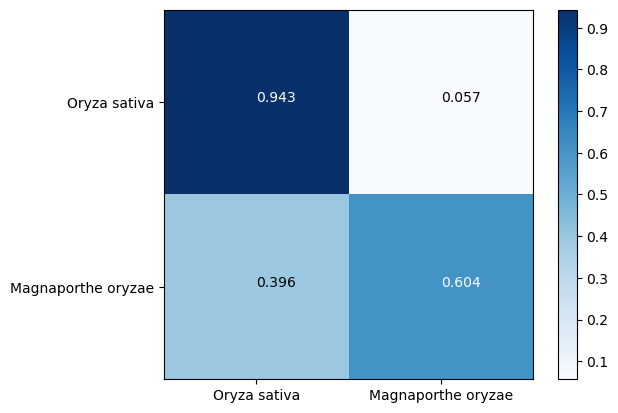

In [51]:
conf=np.array(cm)
row_sums = conf.sum(axis=1)
conf = conf / row_sums[:, np.newaxis]
plt.imshow(conf,cmap='Blues')
species_list=['Oryza sativa','Magnaporthe oryzae']
plt.xticks(range(len(species_list)), species_list)
plt.yticks(range(len(species_list)), species_list)
midpoint = np.mean((np.min(conf), np.max(conf)))
for i in range(len(species_list)):
    for j in range(len(species_list)):
        if conf[i,j] > midpoint:
            colour='white'
        else:
            colour='black'
        plt.text(j,i,f'{np.round(conf[i,j],decimals=3)}',color=colour)
plt.colorbar()
plt.show()